In [1]:
import numpy as np
from scipy import linalg
from scipy import optimize
import sympy as sm

To start with we will base our analysis on a standard Solow-model with technology growth, which we will later expand with human capital. Afterwards we will look at diffrent shocks to the economy and analyze them. First lets define our variables. We have the following:

1. $ K_{t}= Capital$
2. $L_t = Labor$
3. $A_t = Technology$
4. $Y_t = F(K_t,A_t,L_t) = GDP$

Where we have that $L_t$ is growing with the constant rate n and $A_t$ is growing with the constant rate g

First we define our parameters

In [2]:
k = sm.symbols('k')
alpha = sm.symbols('alpha')
delta = sm.symbols('delta')
s = sm.symbols('s')
g = sm.symbols('g')
n = sm.symbols('n')

From this we can write up our steady-state as code and solve for $ {k}^{\ast}$ with sympy

In [6]:
f=k**alpha
ss=sm.Eq(k,(s*f+(1-delta)*k)/((1+n)*(1+g)))
kss=sm.solve(ss,k)[0]
kss

((delta + g*n + g + n)/s)**(1/(alpha - 1))

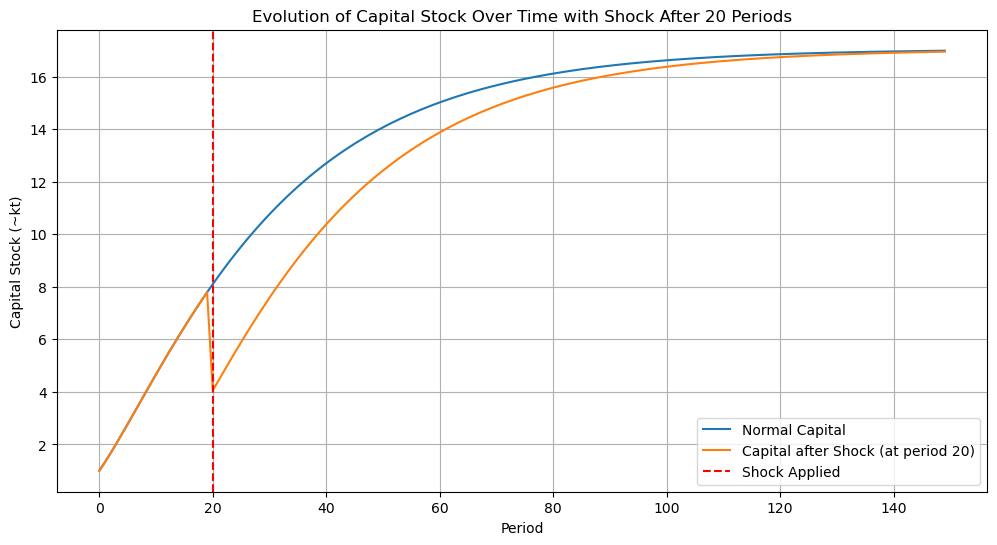

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
alpha = 1/3
n = 0.02
g = 0.02
s = 0.4
delta = 0.02

# Simulation setup
periods = 150
threshold = 0.01 

def next_period_capital(k_tilde, s, alpha, delta, n, g):
    return (1 / ((1 + n) * (1 + g))) * (s * k_tilde**alpha + (1 - delta) * k_tilde)

# Initialize capital arrays
k_tilde_normal = np.zeros(periods)
k_tilde_shock = np.zeros(periods)
k_tilde_normal[0] = 1
k_tilde_shock[0] = 1

# Simulate the evolution of capital
for t in range(1, periods):
    k_tilde_normal[t] = next_period_capital(k_tilde_normal[t-1], s, alpha, delta, n, g)
    # Apply a 50% shock to the capital after 20 periods
    if t == 20:
        k_tilde_shock[t] = next_period_capital(k_tilde_shock[t-1], s, alpha, delta, n, g) * 0.5
    else:
        k_tilde_shock[t] = next_period_capital(k_tilde_shock[t-1], s, alpha, delta, n, g)

# Plotting the results with the shock after 20 periods
plt.figure(figsize=(12, 6))
plt.plot(k_tilde_normal, label='Normal Capital')
plt.plot(k_tilde_shock, label='Capital after Shock (at period 20)')
plt.axvline(x=20, color='red', linestyle='--', label='Shock Applied')
plt.xlabel('Period')
plt.ylabel('Capital Stock (\u007Ekt)')
plt.title('Evolution of Capital Stock Over Time with Shock After 20 Periods')
plt.legend()
plt.grid(True)
plt.show()



In [18]:
# Finding the convergenstime when the valus are within 1% of eachother

convergence_time = find_convergence_time(k_tilde_normal, k_tilde_shock, threshold, start_period=21)

convergence_time


110

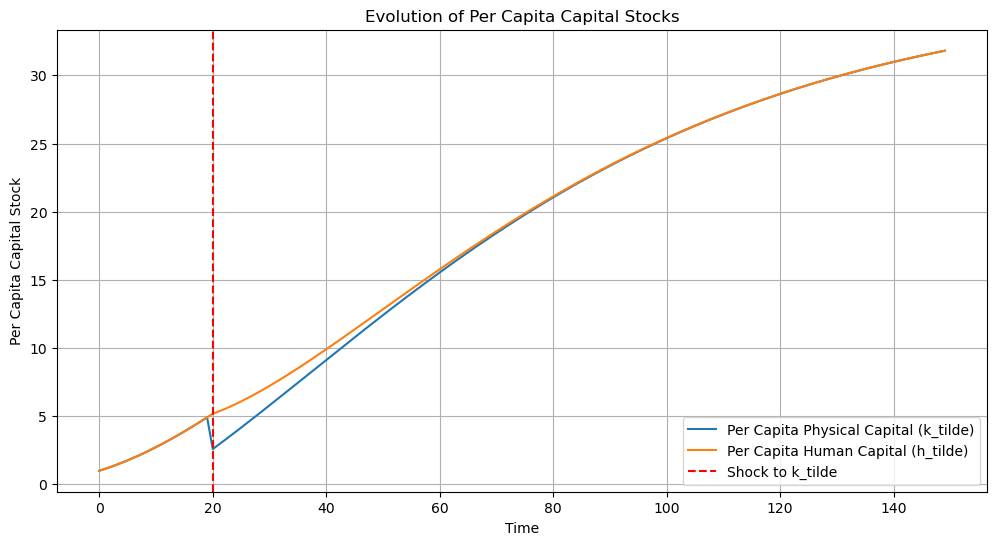

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
alpha = 1/3  # Capital's share of output
phi = 1/3    # Human capital's share of output
s_K = 0.2    # Savings rate for physical capital
s_H = 0.2    # Savings rate for human capital
delta = 0.02 # Depreciation rate
n = 0.02     # Population growth rate
g = 0.02     # Technological growth rate

# Simulation setup
periods = 150
k_tilde = np.zeros(periods)  # Per capita physical capital
h_tilde = np.zeros(periods)  # Per capita human capital
k_tilde[0] = 1  # Initial per capita physical capital
h_tilde[0] = 1  # Initial per capita human capital

# Per capita production function
def per_capita_production(k, h):
    return k**alpha * h**phi

# Run the simulation
for t in range(1, periods):
    y_tilde = per_capita_production(k_tilde[t-1], h_tilde[t-1])
    k_tilde[t] = (s_K * y_tilde + (1 - delta) * k_tilde[t-1]) / (1 + n) / (1 + g)
    h_tilde[t] = (s_H * y_tilde + (1 - delta) * h_tilde[t-1]) / (1 + n) / (1 + g)

    # Apply a 50% shock to physical capital at period 20
    if t == 20:
        k_tilde[t] *= 0.5

# Plotting the evolution of per capita capital over time
plt.figure(figsize=(12, 6))
plt.plot(k_tilde, label='Per Capita Physical Capital (k_tilde)')
plt.plot(h_tilde, label='Per Capita Human Capital (h_tilde)')
plt.axvline(x=20, color='red', linestyle='--', label='Shock to k_tilde')
plt.title('Evolution of Per Capita Capital Stocks')
plt.xlabel('Time')
plt.ylabel('Per Capita Capital Stock')
plt.legend()
plt.grid(True)
plt.show()





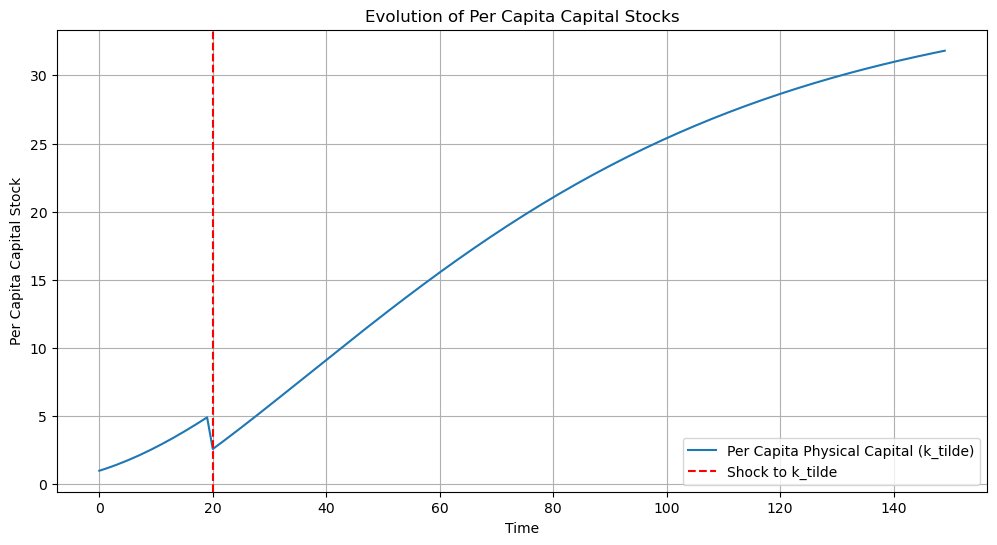

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
alpha = 1/3  # Capital's share of output
phi = 1/3    # Human capital's share of output
s_K = 0.2    # Savings rate for physical capital
s_H = 0.2    # Savings rate for human capital
delta = 0.02 # Depreciation rate
n = 0.02     # Population growth rate
g = 0.02     # Technological growth rate

# Simulation setup
periods = 150
k_tilde = np.zeros(periods)  # Per capita physical capital
h_tilde = np.zeros(periods)  # Per capita human capital
k_tilde[0] = 1  # Initial per capita physical capital
h_tilde[0] = 1  # Initial per capita human capital

# Per capita production function
def per_capita_production(k, h):
    return k**alpha * h**phi

# Run the simulation
for t in range(1, periods):
    y_tilde = per_capita_production(k_tilde[t-1], h_tilde[t-1])
    k_tilde[t] = (s_K * y_tilde + (1 - delta) * k_tilde[t-1]) / (1 + n) / (1 + g)
    h_tilde[t] = (s_H * y_tilde + (1 - delta) * h_tilde[t-1]) / (1 + n) / (1 + g)

    # Apply a 50% shock to physical capital at period 20
    if t == 20:
        k_tilde[t] *= 0.5

# Define the threshold for "closeness"
threshold = 0.01  # 1% of the normal capital stock

# Function to find when the capital stocks get within the threshold
def find_convergence_time(k_normal, k_shock, threshold, start_period):
    for t in range(start_period, len(k_normal)):
        if np.abs(k_normal[t] - k_shock[t]) < threshold * k_normal[t]:
            return t
    return None

# Calculate the convergence time starting after the shock
convergence_time = find_convergence_time(k_tilde, k_tilde_shock, threshold, start_period=21)

# Plotting the evolution of per capita capital over time
plt.figure(figsize=(12, 6))
plt.plot(k_tilde, label='Per Capita Physical Capital (k_tilde)')
if convergence_time is not None:
    plt.axvline(x=convergence_time, color='green', linestyle='--', label=f'Convergence at Period {convergence_time}')
plt.axvline(x=20, color='red', linestyle='--', label='Shock to k_tilde')
plt.title('Evolution of Per Capita Capital Stocks')
plt.xlabel('Time')
plt.ylabel('Per Capita Capital Stock')
plt.legend()
plt.grid(True)
plt.show()

# Output the convergence time if found
convergence_time
